In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #capas sin parametros

In [23]:
class Net(nn.Module): # Se crea la clase con herencia
  def __init__(self, num_channels): #Se inicializa junto con los parametros
    super(Net,self).__init__() # se inicizaliza la clase padre
    
    self.num_channels = num_channels # se define el parámetro como atributo.
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self,x):
    #Empieza 3x64x64
    x = self.conv1(x) # num_channels x 64 x 64
    x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
    x = self.conv2(x) # num_channels*2 x 32 x32
    x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
    x = self.conv3(x) # num_channels*4 x16x16
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8
    
    #flatten
    x = x.view(-1, self.num_channels*4*8*8)
    
    #fc
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    
    #log_softmax
    
    x = F.log_softmax(x, dim=1)
    
    return x

## Cargar Datos en Pytorch

In [3]:
# Habilitamos google drive
from google.colab import  drive #importamos google drive
drive.mount('/gdrive')

#le decimos donde hay una nueva libreria 
import sys   #importamos el modelos 
#le damos una ruta
course_path = '/gdrive/My Drive/Investigación/Platzi/Inteligencia Artificial/Deep Learning - Pytorch/dl-pytorch' 

#que la recuerde siempre 
sys.path.append(course_path) 

%cd '/gdrive/My Drive/Investigación/Platzi/Inteligencia Artificial/Deep Learning - Pytorch/dl-pytorch'

# importamos herramienta para visualizar las imagenes
from plot_helpers import imshow

Mounted at /gdrive
/gdrive/My Drive/Investigación/Platzi/Inteligencia Artificial/Deep Learning - Pytorch/dl-pytorch


In [4]:
import os
from PIL import Image # Lo usamos para cargar las imagenes en __getitem__
from torch.utils.data import Dataset # Debemos importar la clase padre Dataset

# Creamos la clase para cargar nuestros datos
class SIGNSDataset(Dataset):
  "Ejemplo de como construir un dataset de imagenes"
  def __init__(self, base_dir, split="train", transform=None):
    # split se debe a que tenemos tres grupos de imagenes en tres carpetas diferentes.
    path = os.path.join(base_dir, "{}_signs".format(split)) # Aquí swicheamos al set que queramos
    files = os.listdir(path) 
    self.filenames = [os.path.join(path, f) for f in files if f.endswith(".jpg")] # Aquí definimos que solo escogemos los archivos terminados en jpg
    
    # Para nuestro caso, el primer caracter del nombre de las imagenes corresponden a las etiquetas
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx]) 
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [5]:
# Importamos los datos
signs = SIGNSDataset('./datasets/64x64_SIGNS')

In [6]:
len(signs)

864

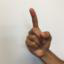

In [7]:
signs[0][0]

In [8]:
signs[0][1]

1

## ¿Cómo entrenar una red en Pytorch?

In [9]:
#Vamos a volver a importar nuestros datos, esta vez transformandolos a tensors

In [10]:
import torchvision.transforms as transforms

trainset = SIGNSDataset('./datasets/64x64_SIGNS',transform=transforms.ToTensor())

In [11]:
from torch.utils.data import DataLoader
dataloader = DataLoader(trainset,batch_size=32)

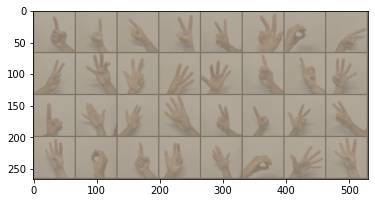

tensor([1, 1, 1, 2, 2, 3, 0, 1, 2, 4, 3, 4, 5, 1, 1, 4, 1, 5, 3, 4, 2, 1, 3, 2,
        4, 0, 1, 3, 5, 0, 5, 4])


In [12]:
# Ahora vamos a ver un batch del data loader

from plot_helpers import imshow
from torchvision.utils import make_grid

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

### Ahora vamos al entrenamiento

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device)) 

Using cuda device


In [24]:
import torch.optim as optim # importamos para definir el optimizador de los parámetros de la red neuronal

net = Net(32).to(device) # Pasamos la red para trabajar con la GPU

loss_fn = nn.NLLLoss() # La función de perdida nos va a mostrar el 'error'
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9) # Creamos el optimizador

In [17]:
#Funcion auxiliar: calcula promedio en el tiempo
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0
    
  def update(self, val, size):
    self.S += val
    self.N += size
    
  def __call__(self):
    return self.S/float(self.N)

In [20]:
num_epochs = 100

In [25]:
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-'*10)
  
  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() #precision
  
  for inputs, targets in dataloader: # Cargamos las imagenes en batches con Dataloader
    inputs, targets = inputs.to(device), targets.to(device) # llevamos los elementos a la GPU
    optimizer.zero_grad() # Reinicia los grandientes a 0
    
    outputs = net(inputs) # Pasamos la imagenes por la red
    _, preds = torch.max(outputs,1) # Miramos el valor predicho, que será el valor máximo de output
    loss = loss_fn(outputs, targets) # Comparamos los valores reales con los predichos
    
    loss.backward() #magias: gradientes calculados automaticamente
    optimizer.step() #magia2: actualiza las perillas o los parametros
    
    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size) # Usamos la función auxiliar que definimos antes para caluclar la perdida
    running_acc.update(torch.sum(preds == targets).float(),
                       batch_size) # Usamos la función auxiliar para calcular la presición
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                          running_acc()))

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 1.7936 Acc: 0.1667 
Epoch 2/100
----------
Loss: 1.7925 Acc: 0.1667 
Epoch 3/100
----------
Loss: 1.7918 Acc: 0.1667 
Epoch 4/100
----------
Loss: 1.7912 Acc: 0.1667 
Epoch 5/100
----------
Loss: 1.7907 Acc: 0.1678 
Epoch 6/100
----------
Loss: 1.7903 Acc: 0.1644 
Epoch 7/100
----------
Loss: 1.7899 Acc: 0.1829 
Epoch 8/100
----------
Loss: 1.7895 Acc: 0.1701 
Epoch 9/100
----------
Loss: 1.7890 Acc: 0.1725 
Epoch 10/100
----------
Loss: 1.7886 Acc: 0.1725 
Epoch 11/100
----------
Loss: 1.7881 Acc: 0.1725 
Epoch 12/100
----------
Loss: 1.7876 Acc: 0.1725 
Epoch 13/100
----------
Loss: 1.7871 Acc: 0.1748 
Epoch 14/100
----------
Loss: 1.7865 Acc: 0.1806 
Epoch 15/100
----------
Loss: 1.7858 Acc: 0.2002 
Epoch 16/100
----------
Loss: 1.7850 Acc: 0.2153 
Epoch 17/100
----------
Loss: 1.7841 Acc: 0.2280 
Epoch 18/100
----------
Loss: 1.7831 Acc: 0.2315 
Epoch 19/100
----------
Loss: 1.7820 Acc: 0.2419 
Epoch 20/100
----------
Loss: 1.7807 Acc: 0.2512 
Epoch 21/100
----------
Loss: 1.